In [349]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import gc
import re

from sklearn import datasets
from sklearn.decomposition import PCA, IncrementalPCA, NMF, TruncatedSVD, FastICA, FactorAnalysis, SparsePCA
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from itertools import cycle
from IPython.display import display
import pickle, os

import seaborn as sns

BES_data_folder = "../BES_analysis_data/"
BES_code_folder = "../BES_analysis_code/"

from fancyimpute import BiScaler, KNN, NuclearNormMinimization, SoftImpute, MICE
from gaussian_kde import gaussian_kde
from utility import display_components,display_pca_data

In [350]:
# del display_components

In [351]:
# fulldata_withPP - all samples, no columns removed due to NAs, preprocessing for weasel answers
# procdata_withPP - light cleaning
# mostdata_withPP - imputation on reduced set, 2% least filled removed
# lessdata_withPP - imputation on reduced set (% lesast filled), but only retain 2/3 filled out data
# core_withPP - just the representative cross-section core
Treatment = "uptodate/"
if not os.path.exists(BES_data_folder+Treatment):
    os.makedirs(BES_data_folder+Treatment)

In [352]:
fname = BES_data_folder+"cat_dictionary"+".pkl"
with open(fname, "rb") as f:
    cat_dictionary = pickle.load( f )
print("cat_dictionary", len( cat_dictionary ) )

cat_dictionary 650


In [353]:
var_type    = pd.read_hdf( BES_data_folder+"var_type.hdf", "var_type" )
print("var_type",  var_type.shape )

var_type (733, 1)


In [354]:
BES_reduced = pd.read_hdf(BES_data_folder+"BES_reduced.hdf","BES_reduced")
print("BES_reduced",  BES_reduced.shape )

BES_numeric = pd.read_hdf( BES_data_folder+"BESW8numeric.hdf", "BESW8numeric" )
print("BES_numeric",  BES_numeric.shape )

BES_reduced (31409, 454)
BES_numeric (31409, 659)


In [355]:
BES_reduced_with_na = pd.read_hdf(BES_data_folder+"BES_reduced_with_na.hdf","BES_reduced_with_na")
print("BES_reduced_with_na",  BES_reduced.shape )

# load decomp object
fname = BES_data_folder+"new_old_col_names.pkl"
with open(fname, "rb") as f:
    new_old_col_names = pickle.load(f)     

BES_reduced_with_na (31409, 454)


In [356]:
# # reduce to representative core
# BES_Panel = pd.read_stata(BES_data_folder+"BES2015_W8_v1.3.dta") # 130Mb
# BES_reduced = BES_reduced.loc[ BES_Panel['wt_core_W8'].notnull() , : ]
# BES_numeric = BES_numeric.loc[ BES_Panel['wt_core_W8'].notnull() , : ]

In [357]:
# normalise data (subtract out the mean, divide through by standard deviation)
clean_feature_set_std = StandardScaler().fit_transform(BES_reduced.values )
BES_std = pd.DataFrame(      clean_feature_set_std,
                             columns = BES_reduced.columns,
                             index   = BES_reduced.index      )

In [358]:
%%time
## RUN (some variant of) PCA (potentially v slow!)

# (svd_solver='full', n_components='mle',whiten=True)
#decomp = PCA(svd_solver='full')
#decomp = FastICA(algorithm='deflation', fun='exp', fun_args=None, max_iter=1000,
 #    n_components=None, random_state=None, tol=0.07, w_init=None, whiten=False) # 2h 1min 4s "fast"
# decomp = SparsePCA(n_components=30, alpha=2,max_iter=1000,n_jobs=4,tol=1e-10, verbose=True) # 5min
#
# alpha=2 -> 1hr
decomp = FactorAnalysis(svd_method = 'lapack') ## ~10s ,n_components=30 -> 1.5 hrs
# ,n_components=30

X_r = decomp.fit_transform(BES_std)
n_components = decomp.components_.shape[0]
BES_decomp = pd.DataFrame(   X_r,
                             columns = range(0,n_components),
                             index   = BES_reduced.index)

Wall time: 7.53 s


In [359]:
treatdir = BES_data_folder+Treatment
# subdir = BES_data_folder+Treatment+decomp_method
load_suff = "FactorAnalysis"
save = True # False => Load

if save & ( 'decomp' in globals() ): # SAVE    ##( 'decomp' not in globals() )
    decomp_method = str(decomp).split("(")[0] 
    subdir = treatdir + "/" + decomp_method
    fname = subdir+decomp_method
    # create dir, save decomp object, BES_decomp, BES_std    
    if not os.path.exists(subdir): os.makedirs(subdir)
    with open(fname+".pkl", "wb") as f: pickle.dump( decomp, f )
    BES_decomp.to_hdf(fname+".hdf"        , decomp_method)
    BES_std.to_hdf(   fname+"_std"+".hdf" , decomp_method)
    
else: # LOAD decomp results (default is SAVE)
    decomp_method = load_suff
    subdir = treatdir + "/" + decomp_method    
    fname = subdir+decomp_method
    if not os.path.exists(subdir): raise Exception(subdir + ' does not exist!')
    # load decomp object, BES_decomp, BES_std, n_components
    with open(fname+".pkl", "rb") as f: decomp = pickle.load(f) 
    BES_decomp = pd.read_hdf(fname+".hdf")
    BES_std    = pd.read_hdf(fname+"_std"+".hdf")
    n_components = decomp.components_.shape[0] 

In [360]:
# # %%time
# # import importlib.util
# # import utility
# # importlib.reload(utility)
# # from utility import display_components

# import imp; imp.reload(utility)
# del display_components
# from utility import display_pca_data

average log-likelihood of all samples: -553.3288632854208
number of iterations: 3


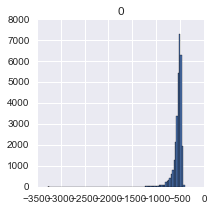

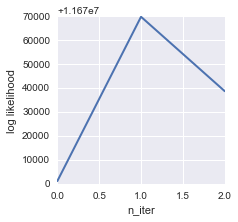

In [361]:
display_pca_data(n_components, decomp, BES_std)

In [362]:
# del display_components

In [363]:
# 0.07954041   0.03892755   0.03553862   0.01885494    0.01562524  
# 50.4286187   24.68006591  22.53148776  11.95403344   9.90639926

In [364]:
decomp

FactorAnalysis(copy=True, iterated_power=3, max_iter=1000, n_components=None,
        noise_variance_init=None, random_state=0, svd_method='lapack',
        tol=0.01)

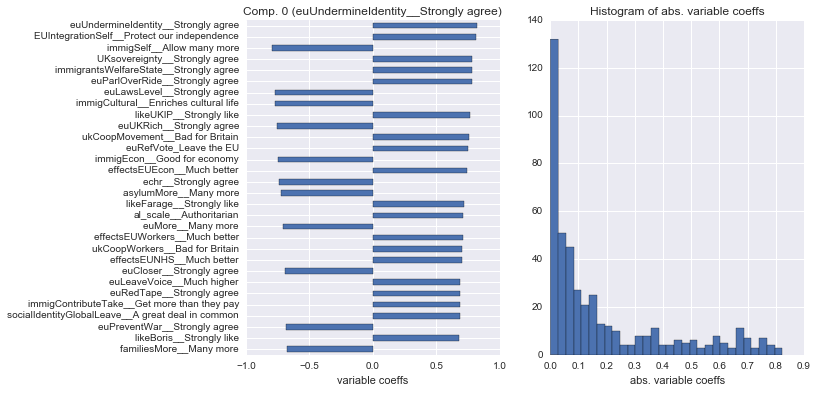

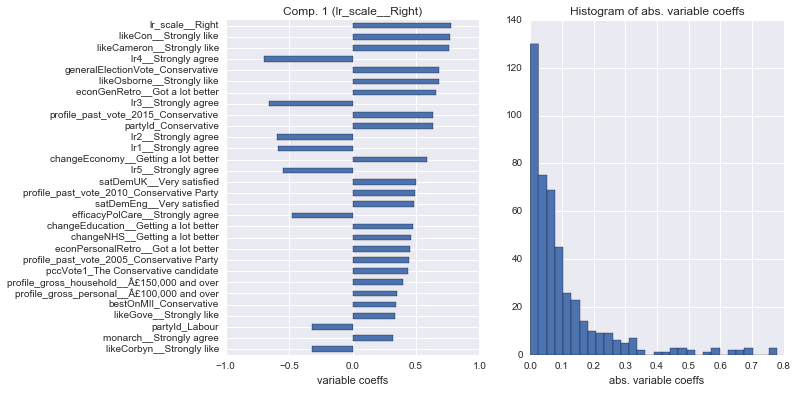

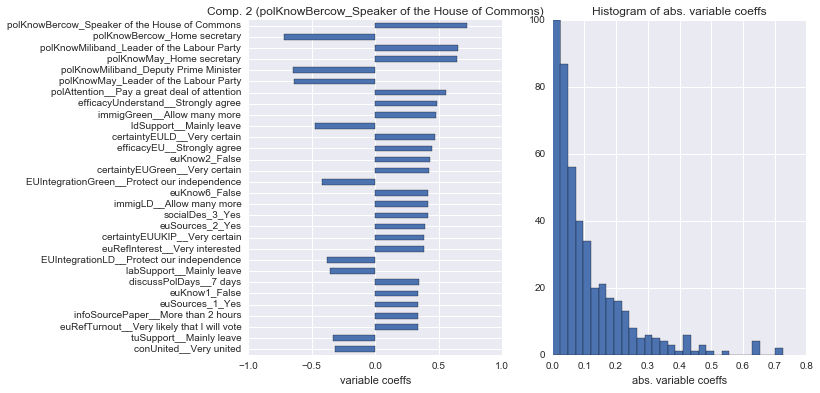

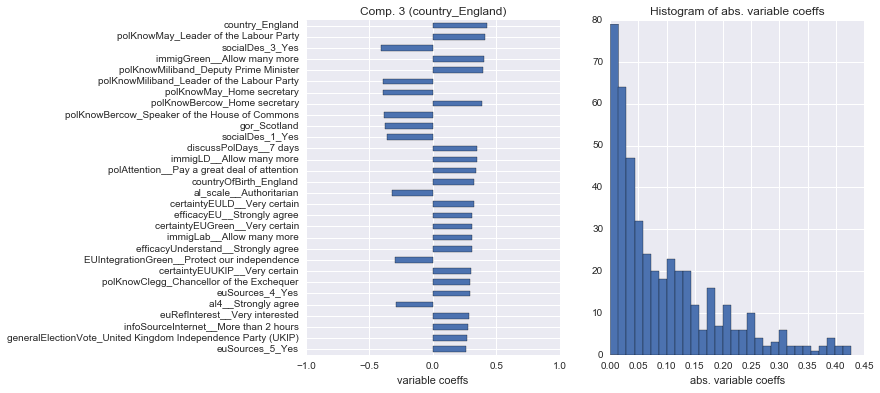

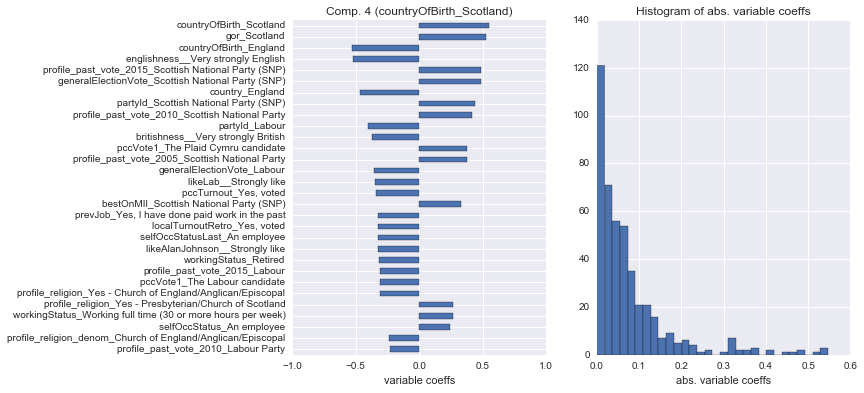

In [365]:
# %%time
(BES_decomp, comp_labels) = display_components(n_components, decomp, subdir, BES_reduced.columns, BES_decomp)

In [366]:
x_axis = 0
y_axis = 1

xlim = np.floor( BES_decomp.loc[ :, x_axis ].min() ), np.ceil( BES_decomp.loc[ :, x_axis ].max() )
ylim = np.floor( BES_decomp.loc[ :, y_axis ].min() ), np.ceil( BES_decomp.loc[ :, y_axis ].max() )

# SparsePCA
if suff == 'SparsePCA':
    xlim =  BES_decomp.loc[ :, x_axis ].min() ,  BES_decomp.loc[ :, x_axis ].max() 
    ylim =  BES_decomp.loc[ :, y_axis ].min() ,  BES_decomp.loc[ :, y_axis ].max() 

In [367]:
# BES_decomp.index
# BES_reduced.loc[BES_decomp.index,decomp_label_col].shape

In [368]:
# # for ordinal categorical
# # winter, autumn
# cmap_name = "winter"
# decomp_label_col = 'lr_scale__Right'
# label_stub = decomp_label_col.split("__")[0]

# fig = plt.figure( figsize=(16,10) )
# plt.scatter(BES_decomp.loc[ :, x_axis ],
#             BES_decomp.loc[ :, y_axis ],
#             cmap = plt.get_cmap(cmap_name),
#             c = BES_reduced.loc[BES_decomp.index,decomp_label_col].values,
#             edgecolor = "None",
#             alpha = 0.9) #            edgecolors=col,

# plt.xlim(xlim)
# plt.ylim(ylim)

# cats = cat_dictionary[ label_stub ]
# labels = ( cats[0], str(0), cats[-1], str(len( cats ) - 1) )
# plt.colorbar().set_label('{} = {}, {} = {}'.format(*labels))
# plt.title( 'Decomposition of BES dataset; labelled variable: ' + decomp_label_col )
# plt.xlabel( comp_labels[x_axis] )
# plt.ylabel( comp_labels[y_axis] ) 
# plt.show()

# fig.savefig( BES_data_folder+Treatment+decomp_method+label_stub+".png", bbox_inches='tight' )

In [369]:
# # for ordinal categorical
# # winter, autumn
# cmap_name = "winter"
# decomp_label_col = 'al_scale__Authoritarian'
# label_stub = decomp_label_col.split("__")[0]

# fig = plt.figure( figsize=(16,10) )
# plt.scatter(BES_decomp.loc[ :, x_axis ],
#             BES_decomp.loc[ :, y_axis ],
#             cmap = plt.get_cmap(cmap_name),
#             c = BES_reduced.loc[BES_decomp.index,decomp_label_col].values,
#             edgecolor = "None",
#             alpha = 0.9) #            edgecolors=col,

# plt.xlim(xlim)
# plt.ylim(ylim)

# cats = cat_dictionary[ label_stub ]
# labels = ( cats[0], str(0), cats[-1], str(len( cats ) - 1) )
# plt.colorbar().set_label('{} = {}, {} = {}'.format(*labels))
# plt.title( 'Decomposition of BES dataset; labelled variable: ' + decomp_label_col )
# plt.xlabel( comp_labels[x_axis] )
# plt.ylabel( comp_labels[y_axis] ) 
# plt.show()

# fig.savefig( BES_data_folder+Treatment+decomp_method+label_stub+".png", bbox_inches='tight' )

,noise_variance_
lr_scale__Right,0.094153
al_scale__Authoritarian,0.106772
likeCon__Strongly like,0.164078
likeUKIP__Strongly like,0.174829
polKnowBercow_Speaker of the House of Commons,0.184317
polKnowBercow_Home secretary,0.185034
polKnowMiliband_Deputy Prime Minister,0.199685
polKnowMiliband_Leader of the Labour Party,0.199856
country_England,0.200479
immigSelf__Allow many more,0.208202


,noise_variance_
bestOnMII_Other party,0.904789
countryOfBirth_Northern Ireland,0.917870
education_Youth training certificate/skillseekers,0.911403
education_onc,0.917919
euMIISmall_EU integration/stability,0.934344
euMIISmall_EU spending/regulations/cost,0.910214
euMIISmall_Family,0.934344
euMIISmall_Other stability or uncertainty concern,0.924564
euMIISmall_Social identity/partisanship,0.912895
marital_Civil Partnership,0.904419


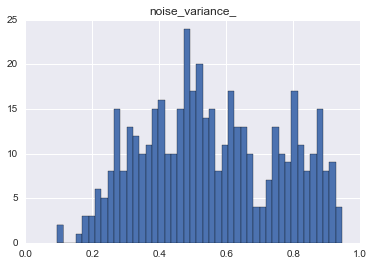

In [370]:
# SUPER USEFUL FOR FEATURE EXTRACTION/VARIABLE PREP!

if hasattr(decomp, 'noise_variance_'):
    if not isinstance(decomp.noise_variance_, float):
        NoiseVariance = pd.DataFrame( decomp.noise_variance_ , index = BES_std.columns, columns = ["noise_variance_"])
        NoiseVariance.hist( bins = int(len( NoiseVariance )/10) )
        NoiseVariance = NoiseVariance.sort_values(by="noise_variance_")
        display( NoiseVariance )
        display( NoiseVariance[ NoiseVariance["noise_variance_"]>.9 ].sort_index() )

In [371]:
# # who are the "improbables"?

# if hasattr(decomp, 'score_samples'):
#     most_likely = pd.DataFrame(decomp.score_samples(BES_std)).quantile(.999).values[0]
#     least_likely = pd.DataFrame(decomp.score_samples(BES_std)).quantile(.001).values[0]
#     print("least likely")
#     display(BES_num_and_cat.loc[ BES_reduced.index[decomp.score_samples(BES_std)<least_likely] ])
# # who are the "stereotypes"?
#     print("most likely")
#     display(BES_num_and_cat.loc[ BES_reduced.index[decomp.score_samples(BES_std)>most_likely ] ])
# # check to see balance of missing values!

number of estimated clusters : 1
Wall time: 10.1 s


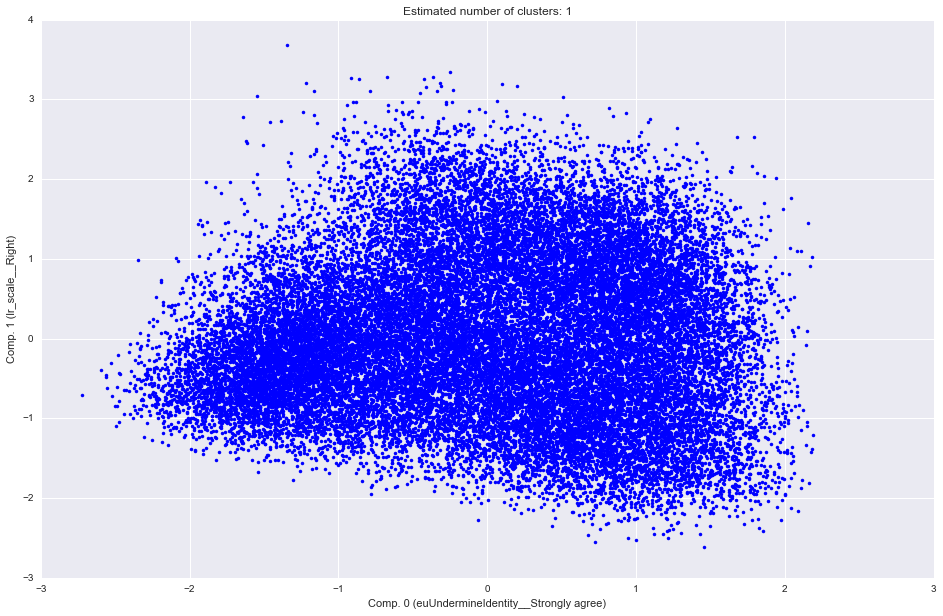

In [372]:
%%time
import numpy as np
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.datasets.samples_generator import make_blobs

X = X_r

# The following bandwidth can be automatically detected using
bandwidth = estimate_bandwidth(X, quantile=0.2, n_samples=500)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X)
labels = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

print("number of estimated clusters : %d" % n_clusters_)


fig = plt.figure( figsize=(16,10) )
plt.clf()

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    my_members = labels == k
    cluster_center = cluster_centers[k]
    plt.plot(X[my_members, x_axis], X[my_members, y_axis], col + '.')
    plt.plot(cluster_center[x_axis], cluster_center[y_axis], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
    
plt.xlim(xlim)
plt.ylim(ylim)
    
plt.xlabel( comp_labels[x_axis] )
plt.ylabel( comp_labels[y_axis] ) 
plt.title('Estimated number of clusters: %d' % n_clusters_)
# plt.show()

fig.savefig(BES_data_folder+Treatment+decomp_method+"Cluster_estimation.png",bbox_inches='tight')


In [373]:
colours = cycle('ycmkgbr')
markers = cycle('v^<>,oD*x+')

cat_col_mar_dict = {} # category-colour-marker dictionary
# basic set of common ones! 
cat_col_mar_dict['Conservative'] = ('b', '.')
cat_col_mar_dict['Conservative Party'] = ('b', '.')
cat_col_mar_dict['The Conservative candidate']       = ('b', '.')
cat_col_mar_dict['Labour']       = ('r', '.')
cat_col_mar_dict['Labour Party']       = ('r', '.')
cat_col_mar_dict['The Labour candidate']       = ('r', '.')
cat_col_mar_dict['Green Party']  = ('g', '.')
cat_col_mar_dict['The Green candidate']       = ('g', '.')
cat_col_mar_dict['Plaid Cymru']  = ('k', '.')
cat_col_mar_dict['The Plaid Cymru candidate']  = ('k', '.')
cat_col_mar_dict['Scottish National Party']           = ('c', '.')
cat_col_mar_dict['United Kingdom Independence Party'] = ('m', '.')
cat_col_mar_dict['The UKIP candidate'] = ('m', '.')
cat_col_mar_dict['Liberal Democrat']                         = ('orange', '.')
cat_col_mar_dict['Liberal Democrats']                        = ('orange', '.')
cat_col_mar_dict['The Liberal Democrat candidate']                         = ('orange', '.')

In [374]:
# BES_reduced.columns

In [375]:
# BES_Panel["riskScale"]

In [376]:
# [ x for x in BES_reduced.columns if re.match(decomp_label_col + "(__)?", x) ]

# # re.match(decomp_label_col + "__", )

C:\ANACON~1\envs\BES_analysis\lib\site-packages\matplotlib\pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


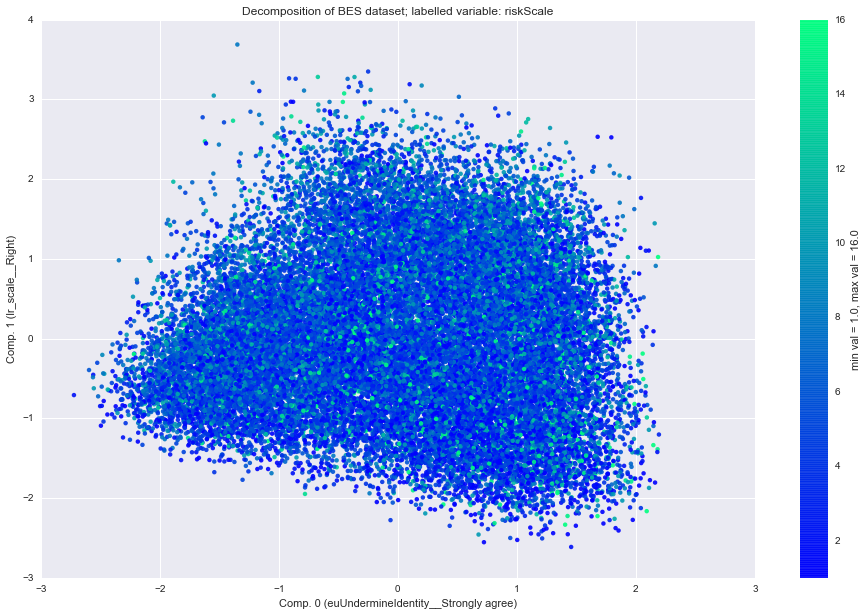

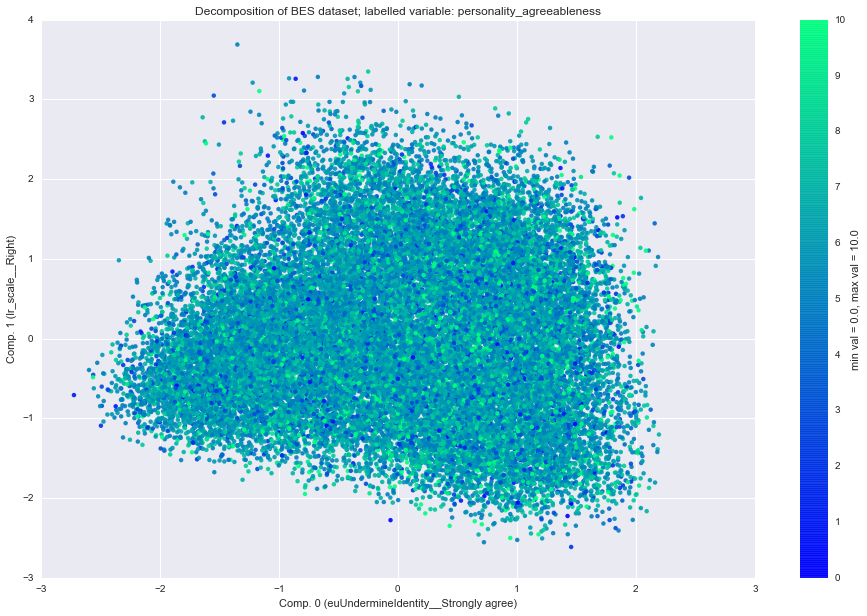

In [377]:
# %%time

graph_type = "ordinal_scatter/"
folder = BES_data_folder+Treatment+decomp_method+graph_type
if not os.path.exists(folder):
    os.makedirs(folder)
    

cmap_name = "winter"
    
dummy_list = var_type[ [ x in [ 0, 1, 2, 5, 6 ] for x in var_type["type"]  ] ].index # 0, 1, 2, 5, 6.index # ordinal variables

# ordinal categories
fig_no = 0
for decomp_label_col in dummy_list:
#     if decomp_label_col in ["profile_religion","country",
#                             'polKnowMay','polKnowOsborne',
#                             'polKnowClegg', 'polKnowBercow',
#                             'polKnowMiliband', 'registered', 'ns_sec']:
#         continue
    
    fig = plt.figure( figsize=(16,10) )

#     # go through all the variables that have been created from base variables through transformation
#     # for ordinal variables, these should only ever be unique matches (unlike non-ordinals)
#     decomp_label_categories = [ x for x in BES_reduced.columns if re.match(decomp_label_col + "_?_?", x) ]
#     if len(decomp_label_categories) == 0: # removed during transformation/reduction
#         continue
#     elif len(decomp_label_categories) > 1:
#         raise Exception('len(decomp_label_categories) > 1 !!!')
#     # c = BES_reduced.loc[BES_decomp.index,decomp_label_col].values,
    
    if (decomp_label_col not in BES_reduced.columns):
        if decomp_label_col in new_old_col_names.keys(): # variable renamed in transformation
            decomp_label_categories = new_old_col_names[decomp_label_col]
        else:
            continue ## variable removed in transformation
    else:
        decomp_label_categories = decomp_label_col
    
    label_stub = decomp_label_col

    plt.scatter(BES_decomp.loc[ :, x_axis ],
                BES_decomp.loc[ :, y_axis ],
                cmap = plt.get_cmap(cmap_name),
                c = BES_reduced.loc[ BES_decomp.index , decomp_label_categories],
                edgecolor = "None",
                alpha = 0.9) #            edgecolors=col,

    plt.xlim(xlim)
    plt.ylim(ylim)

    # get category labels for categorical variables
    if var_type.loc[label_stub,"type"] in [ 1, 2, 5, 6 ]:
        cats = cat_dictionary[ label_stub ]
        labels = ( cats[0], str(0), cats[-1], str(len( cats ) - 1) )
    elif var_type.loc[label_stub,"type"] in [ 0 ]:
        vals = BES_reduced.loc[ BES_decomp.index , decomp_label_categories]
        labels = ( "min val", min(vals), "max val", max(vals) )
    else:
        raise Exception('var_type not in [ 0, 1, 2, 5, 6]')
        
    plt.colorbar().set_label('{} = {}, {} = {}'.format(*labels))
    plt.title( 'Decomposition of BES dataset; labelled variable: ' + decomp_label_col )
    plt.xlabel( comp_labels[x_axis] )
    plt.ylabel( comp_labels[y_axis] ) 
#     plt.show()
    
    fig.savefig( folder+decomp_label_col, bbox_inches='tight' )
    if fig_no >1:
        plt.close()
    fig_no = fig_no + 1
#     print(fig_no)

C:\ANACON~1\envs\BES_analysis\lib\site-packages\matplotlib\pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Wall time: 27.2 s


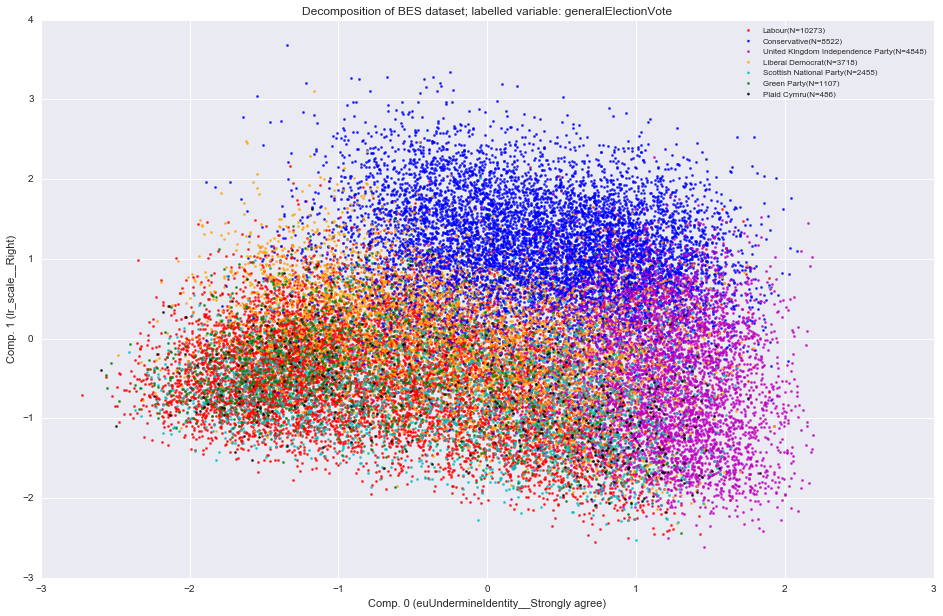

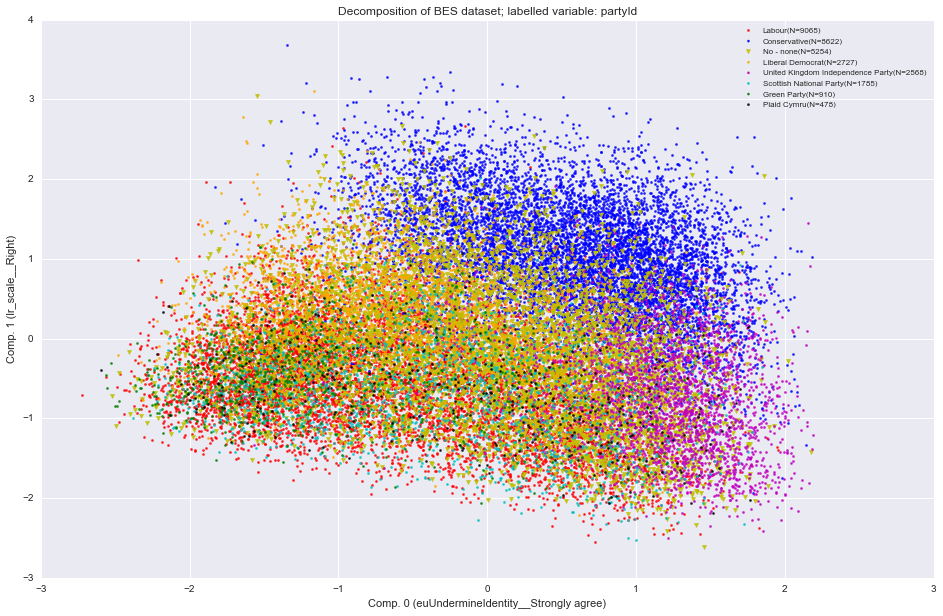

In [378]:
%%time

graph_type = "non_ordinal_scatter/"
folder = BES_data_folder+Treatment+decomp_method+graph_type
if not os.path.exists(folder):
    os.makedirs(folder)

dummy_list = var_type[ var_type["type"]==3 ].index

# non-ordinal categories
fig_no = 0
for decomp_label_col in dummy_list:
    if decomp_label_col in ["profile_religion","country",
                            'polKnowMay','polKnowOsborne',
                            'polKnowClegg', 'polKnowBercow',
                            'polKnowMiliband', 'registered', 'ns_sec']:
        continue
    
    fig = plt.figure( figsize=(16,10) )

    decomp_label_categories = [ x for x in BES_reduced.columns if (decomp_label_col + "_") in x ]
    if len(decomp_label_categories) == 0:
        continue
        
#     if (decomp_label_col not in BES_reduced.columns):
#         if decomp_label_col in new_old_col_names.keys(): # variable renamed in transformation
#             decomp_label_categories = new_old_col_names[decomp_label_col]
#         else:
#             continue ## variable removed in transformation
#     else:
#         decomp_label_categories = decomp_label_col        

    # 'No party is best able to handle this issue'
    drop_cat_list = ['profile_education_age', 'profile_ethnicity_White British']
    for drop_cat in drop_cat_list:
        if drop_cat in decomp_label_categories:
            decomp_label_categories.remove(drop_cat)
            
    replace_dict = {'Scottish National Party (SNP)' : 'Scottish National Party',
                    'United Kingdom Independence Party (UKIP)' : 'United Kingdom Independence Party'}

    lab_to_cat = {}
    sample_sizes = {}
    for cat in decomp_label_categories:
        
        lab = re.search('_([^_]+)$',cat).groups()[0]
        if lab in replace_dict.keys(): # replace party name variants with single version
            lab = replace_dict[lab]
        
        if lab not in cat_col_mar_dict.keys(): # try to give parties consistent colour, marker pairs
            cat_col_mar_dict[lab] = (next(colours),next(markers))
        
        sample_sizes[lab] = sum( BES_reduced[ cat ]==1 )
        lab_to_cat[lab] = cat

    for lab in sorted(sample_sizes, key=sample_sizes.get, reverse=True):
        
        samp = sample_sizes[lab]
            
        (col, mar) = cat_col_mar_dict[lab]

        cat_entries = BES_reduced[ lab_to_cat[lab] ]==1
        
        plt.scatter(BES_decomp.loc[ cat_entries, x_axis ],
                    BES_decomp.loc[ cat_entries, y_axis ],
                    c= col,
                    marker=mar,
                    label=lab + "(N="+str(samp)+")",
                    edgecolors=col,
                    alpha = .9 )
    
    plt.xlim(xlim)
    plt.ylim(ylim)    
    
    plt.xlabel( comp_labels[x_axis] )
    plt.ylabel( comp_labels[y_axis] ) 
    plt.legend(prop={'size':8})
    plt.title('Decomposition of BES dataset; labelled variable: ' + decomp_label_col)
    
    fig.savefig( folder+decomp_label_col, bbox_inches='tight' )
    if fig_no >1:
        plt.close()
    fig_no = fig_no + 1

In [379]:
# col = "euRefVote"

# df = BES_decomp.loc[ : , [x_axis,y_axis] ].copy()
# max_cols = 4

# # reduce length of subcategories
# cats = list(cat_dictionary[col])
# for catno in range( len( cats ) ):

#     words = cats[catno].split(" ")
#     word_array = np.array( [len(x) for x in words] ) + 1
#     max_words = np.where( np.cumsum( word_array )<25 )[0].max()
#     cats[catno] = " ".join( words[0:max_words+1] )


# # add a category column to split the graphs on
# df[col] = BES_numeric[col].astype('category').cat.rename_categories( cats )

# # add N=??? sample size to each category type!
# sample_sizes = df[col].value_counts().loc[cats].values
# cat_plus_sample_sizes = ["".join([x," (N=", str(y),")"]) for x,y in zip(cats, sample_sizes)]
# df[col].cat.rename_categories( cat_plus_sample_sizes, inplace=True )

# # formatting
# n_cols = len(df[col].dropna().unique())
# n_rows = np.ceil(n_cols/max_cols)
# col_wrap = min(max_cols,n_cols)
# size = 13.5/col_wrap

# # make the actual graphs
# g = sns.FacetGrid(df, col=col,size=size,col_wrap=col_wrap)  
# g.map(sns.kdeplot, x_axis, y_axis, shade=True, shade_lowest=False).set_titles("{col_name}")

# # plt.xlim(xlim)
# # plt.ylim(ylim)   
# # plt.xlim(-3, 3)  
# # plt.ylim(-3, 3)

# # labels and title
# plt.subplots_adjust( top = 1-( .05 + .01*n_rows ) )
# g.set_xlabels( comp_labels[x_axis] )
# g.set_ylabels( comp_labels[y_axis] ) 
# g.fig.suptitle(col, fontsize=14, fontweight='bold')

# # save to file
# g.savefig(BES_data_folder+Treatment+decomp_method+col+"_kde", bbox_inches='tight')

In [380]:
# BES_numeric['riskScale'].astype('category')
# df[col].value_counts()
# [str(x) for x in df[col].cat.categories]
# df[col].value_counts().values

Wall time: 2min 51s


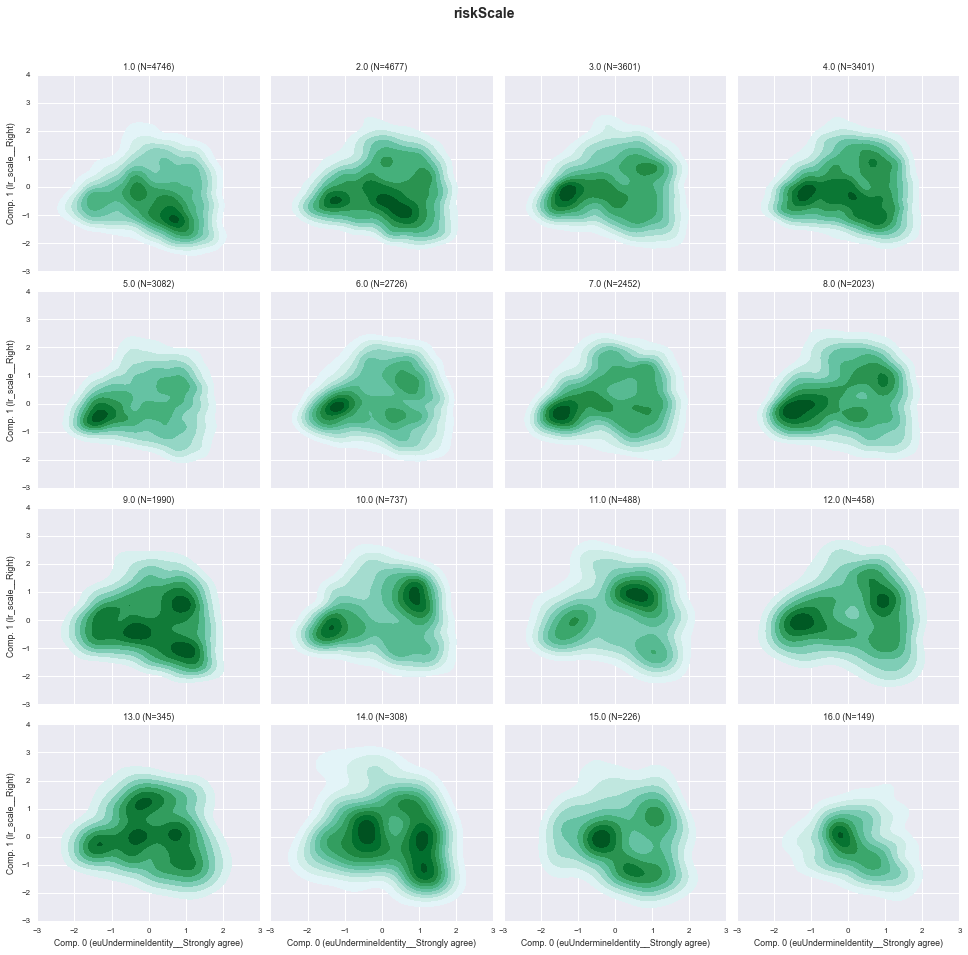

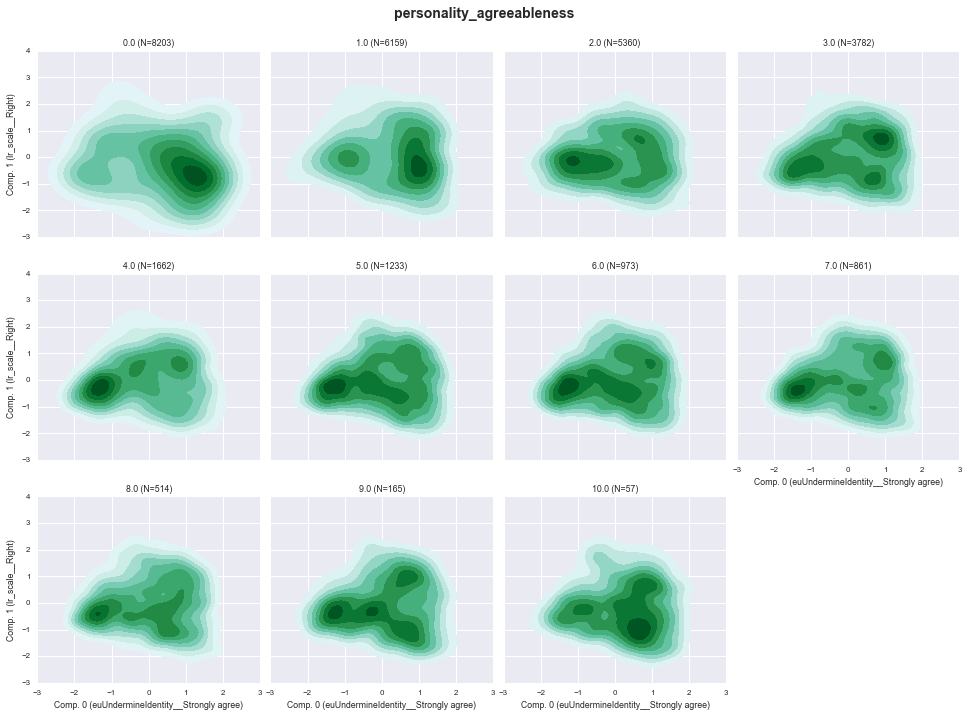

In [381]:
%%time

graph_type = "ordinal_kde/"
folder = BES_data_folder+Treatment+decomp_method+graph_type
if not os.path.exists(folder):
    os.makedirs(folder)

dummy_list = var_type[ [ x in [ 0 ] for x in var_type["type"]  ] ].index # , 1, 2, 5, 6

sns.set(font_scale=.8)

# non-ordinal categories
fig_no = 0
for decomp_label_col in dummy_list:
    if decomp_label_col in ["profile_religion","country",
                            'polKnowMay','polKnowOsborne',
                            'polKnowClegg', 'polKnowBercow',
                            'polKnowMiliband', 'registered',
                            'country_of_residence1','country_of_residence2',
                           'polKnowMiliband', 'polKnowClegg',
       'polKnowOsborne', 'polKnowMay', 'polKnowBercow',
'polKnowKerryW9',
       'polKnowHollandeW9', 'polKnowNetanyahuW9', 'polKnowPutinW9',
       'polKnowMerkelW9', 'polKnowAssadW9', 
       'ns_sec', 'EUMIICategory', 'age', 'Age', 'euRefExpectation',
       'country_of_residence2', 'country_of_residence1', 'profile_lea',
       'profile_oslaua', 'pano',
                           'EUMIICategory']:
        continue
    
#     col = "euRefVote"
#     fig = plt.figure( figsize=(16,10) )
    col = decomp_label_col

    df = BES_decomp.loc[ : , [x_axis,y_axis] ].copy()
    max_cols = 4

#     # get category labels for categorical variables
#     if var_type.loc[label_stub,"type"] in [ 1, 2, 5, 6 ]:
#         cats = cat_dictionary[ label_stub ]
#         labels = ( cats[0], str(0), cats[-1], str(len( cats ) - 1) )
#     elif var_type.loc[label_stub,"type"] in [ 0 ]:
#         vals = BES_reduced.loc[ BES_decomp.index , decomp_label_categories[0] ].values
#         labels = ( "min val", min(vals), "max val", max(vals) )
#     else:
#         raise Exception('var_type not in [ 0, 1, 2, 5, 6]')    
    
    if var_type.loc[col,"type"] in [ 1, 2, 5, 6 ]:
    
        # reduce length of subcategories
        cats = list(cat_dictionary[col])
        for catno in range( len( cats ) ):

            words = cats[catno].split(" ")
            word_array = np.array( [len(x) for x in words] ) + 1
            max_words = np.where( np.cumsum( word_array )<30 )[0].max()
            cats[catno] = " ".join( words[0:max_words+1] )
        # NOTE - can cause problems if 2+ truncated subcategories are identical

        # add a category column to split the graphs on
        df[col] = BES_numeric[col].astype('category').cat.rename_categories( cats )

        # add N=??? sample size to each category type!
        sample_sizes = df[col].value_counts().loc[cats].values        
    elif var_type.loc[col,"type"] in [ 0 ]:
        df[col] = BES_numeric[col].astype('category')
        cats = [str(x) for x in df[col].cat.categories]
        # add N=??? sample size to each category type!
        sample_sizes = df[col].value_counts().values          
    else:
        raise Exception('var_type not in [ 0, 1, 2, 5, 6]')          
        

    cat_plus_sample_sizes = ["".join([x," (N=", str(y),")"]) for x,y in zip(cats, sample_sizes)]
    df[col].cat.rename_categories( cat_plus_sample_sizes, inplace=True )

    # formatting
    n_cols = len(df[col].dropna().unique())
    n_rows = np.ceil(n_cols/max_cols)
    col_wrap = min(max_cols,n_cols)
    size = 13.5/col_wrap

    # make the actual graphs
    g = sns.FacetGrid(df, col=col,size=size,col_wrap=col_wrap)  
    g.map(sns.kdeplot, x_axis, y_axis, shade=True, shade_lowest=False).set_titles("{col_name}")

    plt.xlim(xlim)
    plt.ylim(ylim)   
    # plt.xlim(-3, 3)  
    # plt.ylim(-3, 3)

    # labels and title
    plt.subplots_adjust( top = 1-( .05 + .01*n_rows ) )
    g.set_xlabels( comp_labels[x_axis] )
    g.set_ylabels( comp_labels[y_axis] ) 
    g.fig.suptitle(col, fontsize=14, fontweight='bold')

    # save to file
    g.savefig(folder+col+"_kde", bbox_inches='tight')
    if fig_no >1:
        plt.close()
    fig_no = fig_no + 1

Wall time: 10min 46s


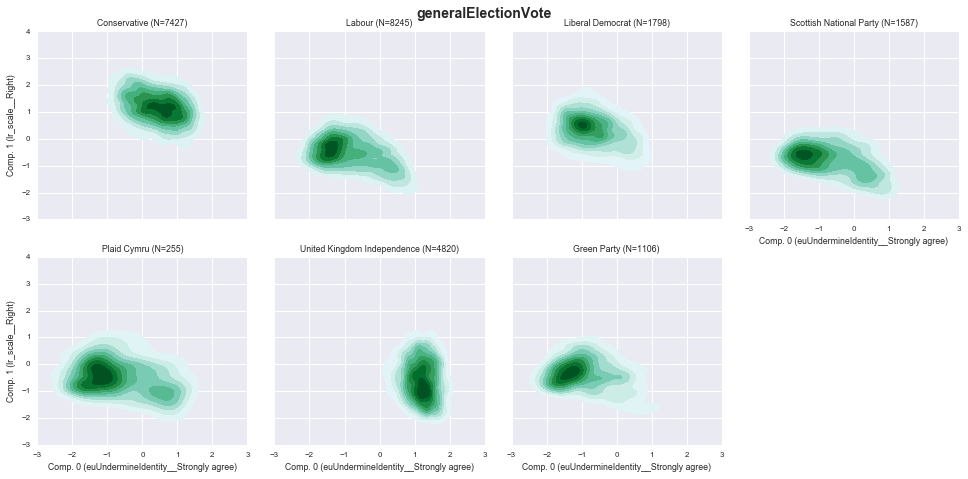

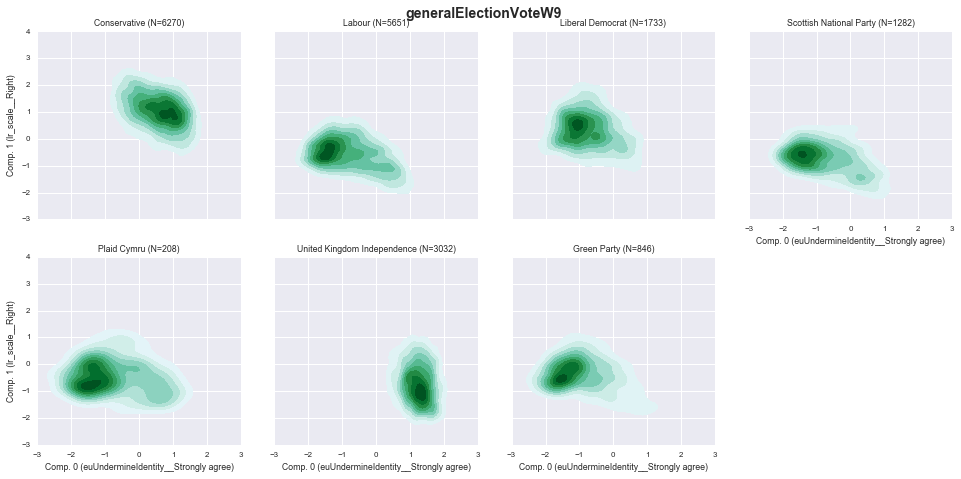

In [382]:
%%time
# 10 minutes!
graph_type = "non_ordinal_kde/"
folder = BES_data_folder+Treatment+decomp_method+graph_type
if not os.path.exists(folder):
    os.makedirs(folder)

dummy_list = var_type[ var_type["type"]==3 ].index

sns.set(font_scale=.8)

# non-ordinal categories
fig_no = 0
for decomp_label_col in dummy_list:
    if decomp_label_col in ["profile_religion","country",
                            'polKnowMay','polKnowOsborne',
                            'polKnowClegg', 'polKnowBercow',
                            'polKnowMiliband', 'registered',
                            'country_of_residence1','country_of_residence2',
                           'polKnowMiliband', 'polKnowClegg',
       'polKnowOsborne', 'polKnowMay', 'polKnowBercow',
'polKnowKerryW9',
       'polKnowHollandeW9', 'polKnowNetanyahuW9', 'polKnowPutinW9',
       'polKnowMerkelW9', 'polKnowAssadW9', 
       'ns_sec', 'EUMIICategory', 'age', 'Age', 'euRefExpectation',
       'country_of_residence2', 'country_of_residence1', 'profile_lea',
       'profile_oslaua', 'pano',
                           'EUMIICategory']:
        continue
    
#     col = "euRefVote"
#     fig = plt.figure( figsize=(16,10) )
    col = decomp_label_col

    df = BES_decomp.loc[ : , [x_axis,y_axis] ].copy()
    max_cols = 4

    # reduce length of subcategories
    cats = list(cat_dictionary[col])
    for catno in range( len( cats ) ):

        words = cats[catno].split(" ")
        word_array = np.array( [len(x) for x in words] ) + 1
        max_words = np.where( np.cumsum( word_array )<30 )[0].max()
        cats[catno] = " ".join( words[0:max_words+1] )
    # NOTE - can cause problems if 2+ truncated subcategories are identical

    # add a category column to split the graphs on
    df[col] = BES_numeric[col].astype('category').cat.rename_categories( cats )

    # add N=??? sample size to each category type!
    sample_sizes = df[col].value_counts().loc[cats].values
    cat_plus_sample_sizes = ["".join([x," (N=", str(y),")"]) for x,y in zip(cats, sample_sizes)]
    df[col].cat.rename_categories( cat_plus_sample_sizes, inplace=True )

    # formatting
    n_cols = len(df[col].dropna().unique())
    n_rows = np.ceil(n_cols/max_cols)
    col_wrap = min(max_cols,n_cols)
    size = 13.5/col_wrap

    # make the actual graphs
    g = sns.FacetGrid(df, col=col,size=size,col_wrap=col_wrap)  
    g.map(sns.kdeplot, x_axis, y_axis, shade=True, shade_lowest=False).set_titles("{col_name}")

    plt.xlim(xlim)
    plt.ylim(ylim)   
    # plt.xlim(-3, 3)  
    # plt.ylim(-3, 3)

    # labels and title
    plt.subplots_adjust( top = 1-( .05 + .01*n_rows ) )
    g.set_xlabels( comp_labels[x_axis] )
    g.set_ylabels( comp_labels[y_axis] ) 
    g.fig.suptitle(col, fontsize=14, fontweight='bold')

    # save to file
    g.savefig(BES_data_folder+Treatment+decomp_method+col+"_kde", bbox_inches='tight')
    if fig_no >1:
        plt.close()
    fig_no = fig_no + 1

Wall time: 22.4 s


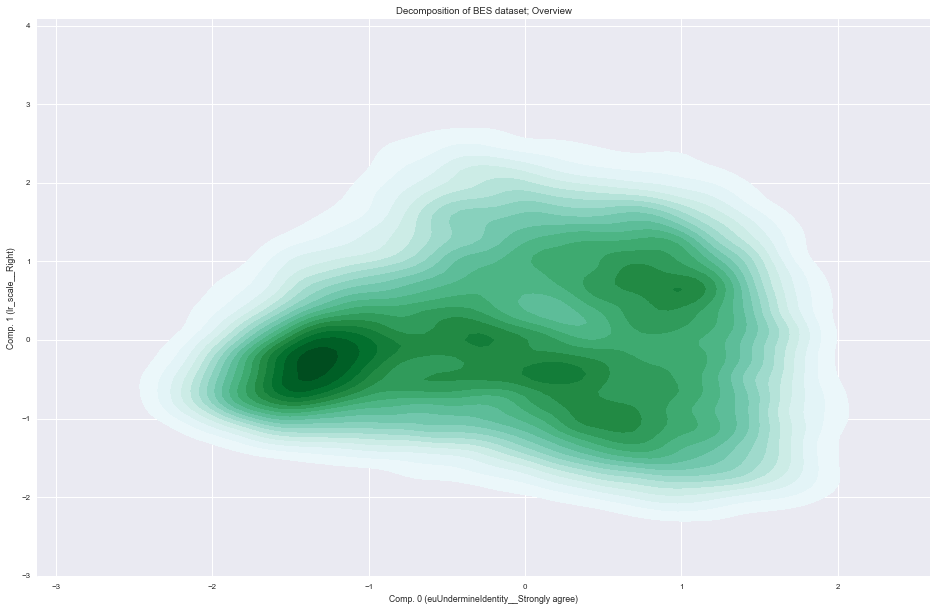

In [383]:
%%time
# col = "edlevel"

# df = BES_decomp.loc[ : , [x_axis,y_axis] ].copy()
# max_cols = 4

# # reduce length of subcategories
# cats = list(cat_dictionary[col])
# for catno in range( len( cats ) ):

#     words = cats[catno].split(" ")
#     word_array = np.array( [len(x) for x in words] ) + 1
#     max_words = np.where( np.cumsum( word_array )<25 )[0].max()
#     cats[catno] = " ".join( words[0:max_words+1] )


# add a category column to split the graphs on
# df[col] = BES_numeric[col].astype('category').cat.rename_categories( cats )

# # add N=??? sample size to each category type!
# sample_sizes = df[col].value_counts().loc[cats].values
# cat_plus_sample_sizes = ["".join([x," (N=", str(y),")"]) for x,y in zip(cats, sample_sizes)]
# df[col].cat.rename_categories( cat_plus_sample_sizes, inplace=True )

# # formatting
# n_cols = len(df[col].dropna().unique())
# n_rows = np.ceil(n_cols/max_cols)
# col_wrap = min(max_cols,n_cols)
# size = 13.5/col_wrap

# make the actual graphs
# g = sns.FacetGrid(df, col=col,size=size,col_wrap=col_wrap)  
fig = plt.figure( figsize=(16,10) )
sns.kdeplot(BES_decomp.loc[ : , [x_axis,y_axis] ],
            shade=True, shade_lowest=False, n_levels=20) #, shade=True, shade_lowest=False)
# g.set_titles("{col_name}")

# plt.xlim(xlim)
# plt.ylim(ylim)   
# plt.xlim(-3, 3)  
# plt.ylim(-3, 3)

# labels and title
# plt.subplots_adjust( top = 1-( .05 + .01*n_rows ) )
# g.set_xlabels( comp_labels[x_axis] )
# g.set_ylabels( comp_labels[y_axis] ) 
# g.fig.suptitle(col, fontsize=14, fontweight='bold')
plt.xlabel( comp_labels[x_axis] )
plt.ylabel( comp_labels[y_axis] ) 
plt.title('Decomposition of BES dataset; Overview')
# save to file
fig.savefig(BES_data_folder+Treatment+decomp_method+"overview"+"_kde", bbox_inches='tight')

In [384]:
# %%time
# # Load BES Panel for Wave 8
# BES_Panel = pd.read_stata(BES_data_folder+"BES2015_W8_v1.3.dta") # 130Mb
# #(31409, 733)

# # BES_Panel = pd.read_stata(BES_data_folder+BES2015_W8_v1.6.dta")

# print( BES_Panel.shape )

In [385]:
# BES_Panel = pd.read_stata(BES_data_folder+"BES2015_W8_v1.3.dta")
# weights = BES_Panel['wt_full_W8']
# print(weights.shape)

# samples = BES_decomp.loc[ : , [x_axis,y_axis] ]
# samples = np.swapaxes(samples,0,1)
# print(samples.shape)

In [386]:
# #create mesh grid
# x = np.linspace(xlim[0], xlim[1], 100)
# y = np.linspace(ylim[0], ylim[1], 100)
# xx, yy = np.meshgrid(x, y)

In [387]:
# #Evaluate the kde on a grid
# pdf = gaussian_kde(samples.values, weights=weights.values)
# zz = pdf((np.ravel(xx), np.ravel(yy)))
# zz = np.reshape(zz, xx.shape)

In [388]:
# gc.collect()

In [389]:
# kwargs = dict(extent=(xlim[0], xlim[1], ylim[0], ylim[1]), cmap='hot', origin='lower')

In [390]:
# plt.figure()
# plt.imshow(zz, **kwargs)
# plt.title('kde')
# plt.tight_layout()
# plt.show()

In [391]:
# from matplotlib import mlab, cm
# levels = np.arange(0, 0.16, 0.01)  # Boost the upper limit to avoid truncation errors.
# norm = cm.colors.Normalize(vmax=abs(zz).max(), vmin=-abs(zz).max())
# cmap = cm.PRGn
# cset1 = plt.contourf(xx, yy, zz, levels,
#                  cmap=cm.get_cmap(cmap, len(levels) - 1),
#                  norm=norm,
#                  )

In [392]:
(x_axis,y_axis,xlim,ylim)

(0, 1, (-3.0, 3.0), (-3.0, 4.0))

In [393]:
BES_Panel = pd.read_stata(BES_data_folder+"BES2015_W8_v1.3.dta")
# weights = BES_Panel['wt_full_W8']
weights = BES_Panel['wt_core_W8'].dropna()
print(weights.shape)

# samples = BES_decomp.loc[ : , [x_axis,y_axis] ]
samples = BES_decomp.loc[ BES_Panel['wt_core_W8'].notnull() , [x_axis,y_axis] ]
samples = np.swapaxes(samples,0,1)
print(samples.shape)

(20404,)
(2, 20404)


Wall time: 13.7 s


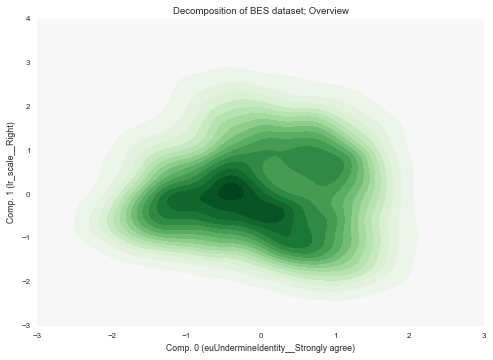

In [394]:
%%time
weighted_kde(xlim, ylim, samples, weights)

In [395]:
gc.collect()

1469691

In [396]:
comp_labels

{0: 'Comp. 0 (euUndermineIdentity__Strongly agree)',
 1: 'Comp. 1 (lr_scale__Right)',
 2: 'Comp. 2 (polKnowBercow_Speaker of the House of Commons)',
 3: 'Comp. 3 (country_England)',
 4: 'Comp. 4 (countryOfBirth_Scotland)',
 5: 'Comp. 5 (selfOccStatus_An employee)',
 6: 'Comp. 6 (selfOccStatus_An employee)',
 7: 'Comp. 7 (likeBennett__Strongly like)',
 8: 'Comp. 8 (partyId_Labour)',
 9: 'Comp. 9 (likeLD__Strongly like)',
 10: 'Comp. 10 (profile_ethnicity_White British)',
 11: 'Comp. 11 (profile_religion_denom_None)',
 12: 'Comp. 12 (likeLD__Strongly like)',
 13: 'Comp. 13 (gor_Wales)',
 14: 'Comp. 14 (gor_Wales)',
 15: 'Comp. 15 (socialDesScale__4 items chosen)',
 16: 'Comp. 16 (noDependentsInHousehold_Yes)',
 17: 'Comp. 17 (polKnowClegg_Deputy Prime Minister)',
 18: 'Comp. 18 (headHouseholdPast_My father)',
 19: 'Comp. 19 (generalElectionVote_Liberal Democrat)'}

In [397]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import seaborn; seaborn.set() # set plot style

# https://github.com/jakevdp/wpca
# https://github.com/jakevdp/wpca/blob/master/WPCA-Example.ipynb
from wpca import PCA, WPCA, EMPCA

In [398]:
BES_Panel = pd.read_stata(BES_data_folder+"BES2015_W8_v1.3.dta")
# weights = BES_Panel['wt_full_W8']
row_weights = BES_Panel['wt_full_W8'].dropna()
print(row_weights.shape)

# # samples = BES_decomp.loc[ : , [x_axis,y_axis] ]
# samples = BES_decomp.loc[ BES_Panel['wt_core_W8'].notnull() , [x_axis,y_axis] ]
# samples = np.swapaxes(samples,0,1)
# print(samples.shape)

(31409,)


In [399]:
# thresh = .2
# counts = BES_numeric.count()
# mostly_not_filled_out = counts[counts<= (counts.max()*thresh)].index
# # mostly_filled_out     = counts[counts>  (counts.max()*thresh)].index
# W9_vars = pd.Index([x for x in BES_numeric.columns if "W9" in x])

# many_cat_drop_list = ['Age', 'EUMIICategory', 'age', 'country_of_residence1',
#        'country_of_residence2', 'euRefExpectation', 'ns_sec', 'pano',
#        'profile_lea', 'profile_oslaua']

# high_corr_drop_list = ['ageGroup', 'euRefVote2', 'euRefVotePost', 'euRefVoteUnsqueeze',
#        'recallVote15', 'voted2015']

# very_low_var = ['partyContactLD_6', 'partyContactLD_7', 'partyContactUKIP_1']

# BES_reduced = BES_numeric.copy()
# BES_reduced.drop(W9_vars,               axis=1, inplace=True, errors='ignore')
# BES_reduced.drop(mostly_not_filled_out, axis=1, inplace=True, errors='ignore')
# # BES_reduced.drop(many_cat_drop_list   , axis=1, inplace=True, errors='ignore')
# BES_reduced.drop(high_corr_drop_list  , axis=1, inplace=True, errors='ignore')
# BES_reduced.drop(very_low_var         , axis=1, inplace=True, errors='ignore')
# print(BES_reduced.shape)

In [400]:
BES_reduced_with_na.shape

(31409, 454)

In [401]:
# subsample
# BES_reduced = BES_reduced_with_na[BES_reduced_with_na.columns[0:200]][0:30000].copy()

BES_reduced = BES_reduced_with_na.copy()
BES_reduced = BES_reduced.copy()

In [402]:
# multiply binary null/notnull matrix by the weights for each row (individual)
weights = BES_reduced.notnull().astype('int').apply(lambda x: x*row_weights)
weights = BES_reduced.notnull().astype('int') # just missing values

In [403]:
clean_feature_set_std = StandardScaler().fit_transform(BES_reduced.fillna(0).values )

In [404]:
# "weightPCAreduced_withPP/" - 2% reduced data
# "weightPCAreduced_withPP/"
Treatment = "weightPCAuptodate"
Treatment = "sklearnPCAuptodate"
Treatment = "weightPCAuptodate_weights_just_missing_values"
Treatment = "EMPCAuptodate_weights_just_missing_values"
if not os.path.exists(BES_data_folder+Treatment):
    os.makedirs(BES_data_folder+Treatment)

In [405]:
%%time
from wpca import PCA, WPCA, EMPCA

BES_std = pd.DataFrame(      clean_feature_set_std,
                             columns = BES_reduced.columns,
                             index   = BES_reduced.index      )

# decomp = PCA(svd_solver='full')
# #decomp = FastICA(algorithm='deflation', fun='exp', fun_args=None, max_iter=1000,
#  #    n_components=None, random_state=None, tol=0.07, w_init=None, whiten=False) # 2h 1min 4s "fast"
# # decomp = SparsePCA(n_components=30, alpha=2,max_iter=1000,n_jobs=4,tol=1e-10, verbose=True) # 5min
# #
# # alpha=2 -> 1hr
# decomp = FactorAnalysis(svd_method = 'lapack') ## ~10s ,n_components=30 -> 1.5 hrs
# # ,n_components=30
# PCA, WPCA, EMPCA
# decomp = PCA(n_components=10)
# decomp = EMPCA() # overnight!
# decomp = WPCA() # 21 minutes, 7min 54s (14min 34s) -> rubbish
# decomp = WPCA(n_components=10) # 6.2s -> rubbish
# decomp = WPCA(n_components=30) # 7min 22s -> rubbish
# decomp = EMPCA(n_components=10) # 6.2s # 20min 29s -> and rubbish
#decomp = EMPCA() # more than 8 hours - had to interrupt
weights = []
# decomp = WPCA() #332ms # (n_components=30)
# 20s with weights, 7mins with no weights (weird!)
decomp = EMPCA()
from sklearn.decomposition import PCA
decomp = PCA() # svd_solver='full' # 2s

# decomp_method = "EWPCA" # 21 minutes
if len(weights) ==0:
    kwds = {}
else:
    kwds = {'weights': weights}

X_r = decomp.fit_transform(BES_std, **kwds)
n_components = decomp.components_.shape[0]
BES_decomp = pd.DataFrame(   X_r,
                             columns = range(0,n_components),
                             index   = BES_reduced.index)


Wall time: 2.17 s


In [406]:
Treatment
#EMPCAuptodate_weights_just_missing_values

'EMPCAuptodate_weights_just_missing_values'

In [407]:
decomp_method = str(decomp).split("(")[0]

subdir = BES_data_folder+"/"+Treatment+"/"+decomp_method+"/"
if not os.path.exists(subdir): os.makedirs(subdir)


explained variance ratio (first 30): [ 0.06747569  0.04101264  0.02514567  0.02301436  0.0161522   0.01427518
  0.01271334  0.0099905   0.00930956  0.00874448  0.00805393  0.00731232
  0.00702505  0.00675678  0.00650574  0.00590803  0.00578989  0.00549802
  0.00536493  0.00518804  0.00503245  0.00494268  0.00481457  0.00466741
  0.00451209  0.00449128  0.004451    0.00433458  0.00429063  0.00418199]
explained variance (first 30): [ 30.63396156  18.61974008  11.41613418  10.44851968   7.33309942
   6.48093079   5.77185731   4.53568853   4.22653823   3.96999309
   3.65648522   3.31979443   3.18937446   3.06757636   2.95360479
   2.6822466    2.62861182   2.49610321   2.43567643   2.35537159
   2.28473275   2.24397552   2.18581496   2.11900504   2.04849057
   2.03904207   2.02075394   1.96789738   1.94794729   1.89862299]
noise variance: 0.0
average log-likelihood of all samples: -inf


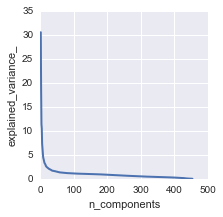

In [408]:
display_pca_data(n_components, decomp, BES_std)

Wall time: 14.9 s


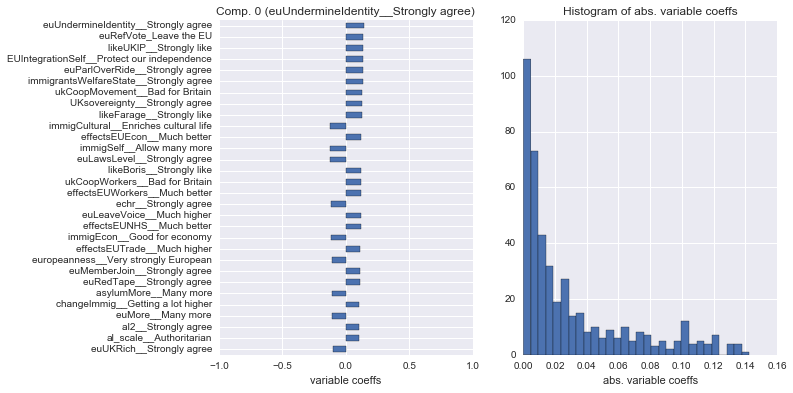

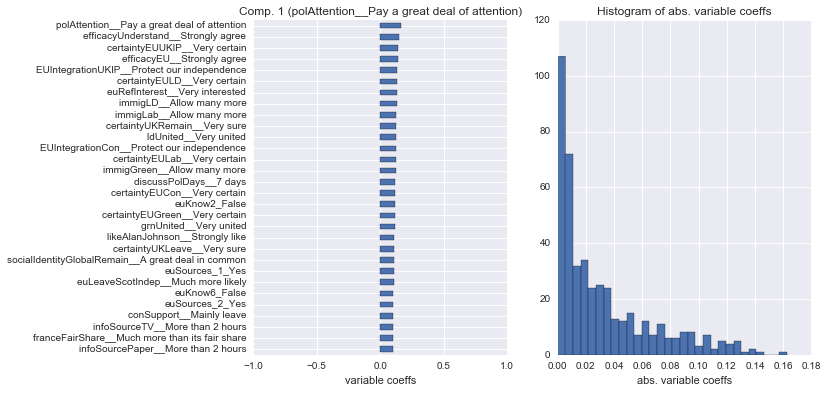

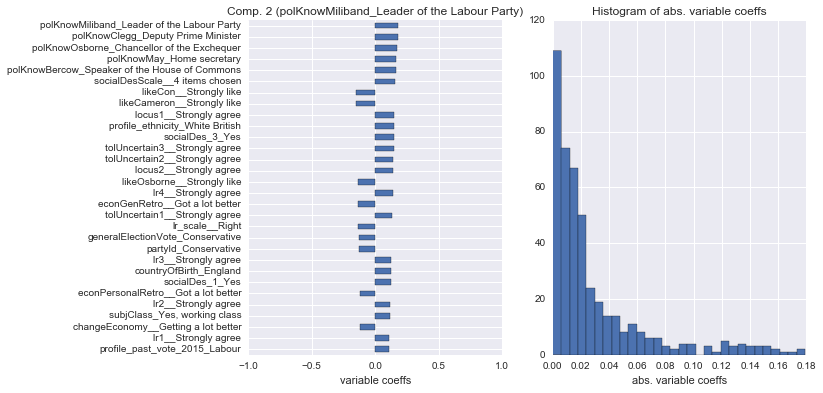

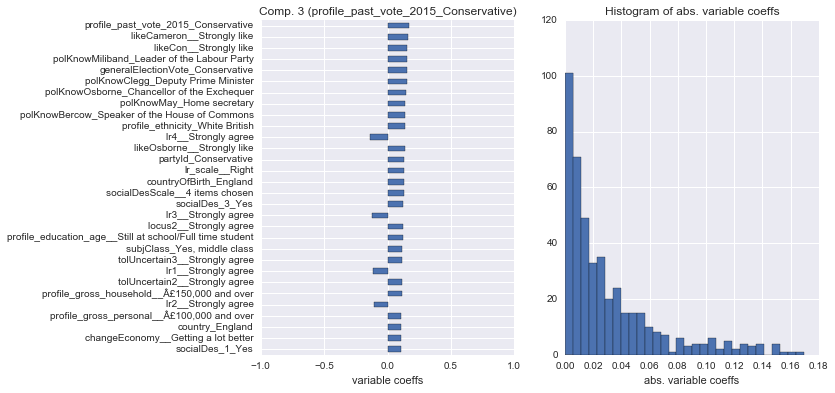

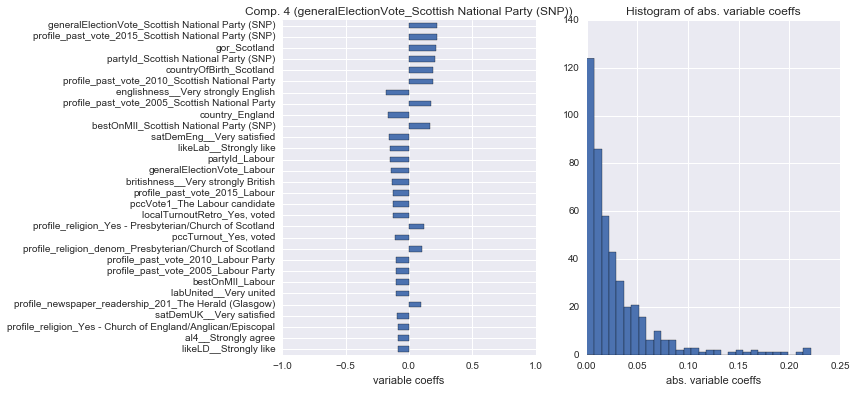

In [409]:
%%time
BES_decomp, comp_labels = display_components(n_components, decomp, subdir, BES_reduced.columns, BES_decomp)

In [410]:
gc.collect()

355261

In [411]:
decomp

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)